# API Evaluation Analysis

This notebook visualizes results from `evaluation/results.csv`:
- Summary metrics (averages)
- Distributions and trends
- Checkpoint timing and size

Update `CSV_PATH` if needed, then run all cells.


In [7]:
# Imports and config
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Inline plots
%matplotlib inline

# Paths
CSV_PATH = os.getenv('EVAL_CSV_PATH', 'results.csv')
FIG_DIR = 'evaluation/figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Read CSV
usecols = None  # read all; robust to extra columns
try:
    df = pd.read_csv(CSV_PATH, usecols=usecols)
except FileNotFoundError:
    raise SystemExit(f'CSV not found at {CSV_PATH}. Set EVAL_CSV_PATH or update CSV_PATH.')

# Normalize numeric columns
numeric_cols = [
    'handshake_ms','submit_ms','status_ms','verify_ai_ms','prove_inclusion_ms','fraud_score'
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Timestamps to datetime if present
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

df.head()


,iteration,timestamp,handshake_ms,log_entry_id,claim_id,fraud_score,model_version,status_tamper_verified,verify_ai_verified,verify_ai_model_version,verify_ai_feature_hash_match,submit_ms,status_ms,verify_ai_ms,prove_inclusion_ms,prove_inclusion_ok,prove_inclusion_path_len,checkpoint_id,checkpoint_merkle_root,checkpoint_ms
0,1,2025-10-30 07:14:41.997524,27.72,84,claim_20251030071441903789_0qrmh8,0.820637,model_v1,False,NaN,NaN,NaN,80.59,7.13,2.88,NaN,False,NaN,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
1,2,2025-10-30 07:14:42.094581,NaN,85,claim_20251030071441997524_63gtgt,0.820637,model_v1,False,NaN,NaN,NaN,80.80,9.53,3.27,NaN,False,NaN,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
2,3,2025-10-30 07:14:42.196860,NaN,86,claim_20251030071442094581_rssln0,0.100749,model_v1,False,NaN,NaN,NaN,90.38,5.82,2.66,NaN,False,NaN,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
3,4,2025-10-30 07:14:42.294180,NaN,87,claim_20251030071442196860_o8y9zt,0.820637,model_v1,False,NaN,NaN,NaN,80.65,9.67,2.93,NaN,False,NaN,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
4,5,2025-10-30 07:14:42.402028,NaN,88,claim_20251030071442294180_6ix94d,0.820637,model_v1,False,NaN,NaN,NaN,94.14,8.35,2.40,NaN,False,NaN,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75


In [8]:
# Summary metrics
summary = {}

if 'handshake_ms' in df.columns:
    # only first row has handshake_ms in current script; compute mean of non-null just in case
    summary['avg_handshake_ms'] = float(df['handshake_ms'].dropna().mean()) if df['handshake_ms'].notna().any() else None

for key in ['submit_ms','status_ms','verify_ai_ms','prove_inclusion_ms','fraud_score']:
    if key in df.columns:
        val = df[key].dropna().mean() if df[key].notna().any() else None
        summary[f'avg_{key}'] = float(val) if val is not None and not math.isnan(val) else None

# Checkpoint info (take any non-empty rows)
chk_id = df['checkpoint_id'].dropna().astype(str).replace('', np.nan).dropna().tail(1).iloc[0] if 'checkpoint_id' in df.columns and df['checkpoint_id'].notna().any() else None
chk_root = df['checkpoint_merkle_root'].dropna().astype(str).replace('', np.nan).dropna().tail(1).iloc[0] if 'checkpoint_merkle_root' in df.columns and df['checkpoint_merkle_root'].notna().any() else None
chk_ms = df['checkpoint_ms'].dropna().tail(1).iloc[0] if 'checkpoint_ms' in df.columns and df['checkpoint_ms'].notna().any() else None

summary_table = pd.DataFrame([
    {
        'PQC Handshake avg (ms)': summary.get('avg_handshake_ms'),
        'Claim Submit avg (ms)': summary.get('avg_submit_ms'),
        'Claim Status avg (ms)': summary.get('avg_status_ms'),
        'Verify AI avg (ms)': summary.get('avg_verify_ai_ms'),
        'Inclusion Proof avg (ms)': summary.get('avg_prove_inclusion_ms'),
        'Fraud Score avg': summary.get('avg_fraud_score'),
        'Checkpoint ID': chk_id,
        'Checkpoint Root': (chk_root[:20] + '...') if isinstance(chk_root, str) else None,
        'Checkpoint Time (ms)': chk_ms,
    }
])
summary_table


,PQC Handshake avg (ms),Claim Submit avg (ms),Claim Status avg (ms),Verify AI avg (ms),Inclusion Proof avg (ms),Fraud Score avg,Checkpoint ID,Checkpoint Root,Checkpoint Time (ms)
0,27.72,79.392885,8.917339,4.111845,None,0.633843,4,54e89b496e2417433731...,84.75


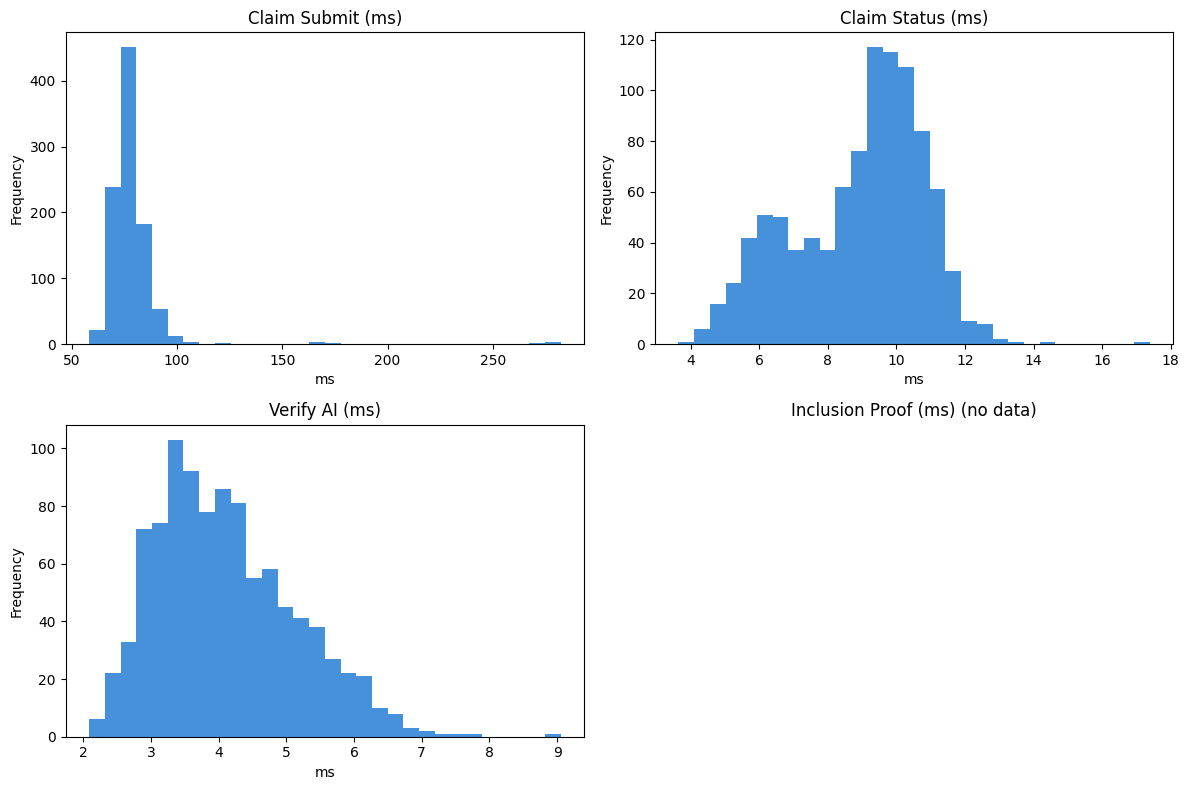

In [9]:
# Distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plots = [
    ('submit_ms', 'Claim Submit (ms)'),
    ('status_ms', 'Claim Status (ms)'),
    ('verify_ai_ms', 'Verify AI (ms)'),
    ('prove_inclusion_ms', 'Inclusion Proof (ms)'),
]

for ax, (col, title) in zip(axes.ravel(), plots):
    if col in df.columns and df[col].notna().any():
        df[col].dropna().plot(kind='hist', bins=30, ax=ax, alpha=0.8, color='#1976d2')
        ax.set_title(title)
        ax.set_xlabel('ms')
    else:
        ax.set_title(f'{title} (no data)')
        ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'distributions.png'), dpi=150)
plt.show()


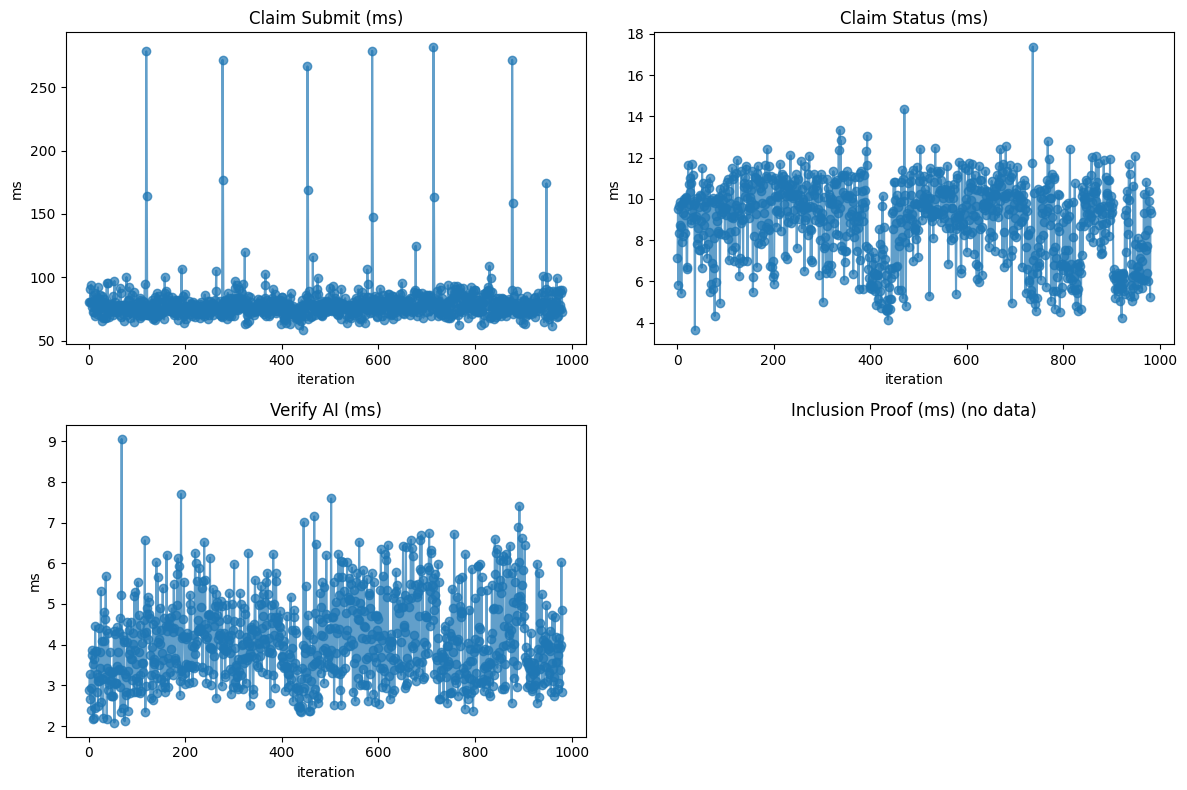

In [10]:
# Time series trends (by iteration or timestamp)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
series = [
    ('submit_ms', 'Claim Submit (ms)'),
    ('status_ms', 'Claim Status (ms)'),
    ('verify_ai_ms', 'Verify AI (ms)'),
    ('prove_inclusion_ms', 'Inclusion Proof (ms)'),
]

x = df['iteration'] if 'iteration' in df.columns else np.arange(len(df))
for ax, (col, title) in zip(axes.ravel(), series):
    if col in df.columns and df[col].notna().any():
        ax.plot(x, df[col], marker='o', linestyle='-', alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel('iteration' if 'iteration' in df.columns else 'index')
        ax.set_ylabel('ms')
    else:
        ax.set_title(f'{title} (no data)')
        ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'timeseries.png'), dpi=150)
plt.show()


In [11]:
# Checkpoint overview
chk_rows = df[(df.get('checkpoint_id').notna() if 'checkpoint_id' in df.columns else False)] if 'checkpoint_id' in df.columns else pd.DataFrame()

if not chk_rows.empty:
    display(chk_rows[['checkpoint_id','checkpoint_merkle_root','checkpoint_ms']].dropna(how='all'))
    # Textual summary similar to script output
    avg_handshake = df['handshake_ms'].dropna().mean() if 'handshake_ms' in df.columns else None
    avg_submit = df['submit_ms'].dropna().mean() if 'submit_ms' in df.columns else None
    last_chk = chk_rows.tail(1).iloc[0]
    z_entries = None  # Not directly in CSV; taken from script context
    lines = []
    if not pd.isna(avg_handshake):
        lines.append(f"PQC Handshake (Kyber): average {avg_handshake:.2f} ms")
    if not pd.isna(avg_submit):
        lines.append(f"Claim Submission: average {avg_submit:.2f} ms")
    if 'checkpoint_ms' in chk_rows.columns and not pd.isna(last_chk['checkpoint_ms']):
        lines.append(f"Checkpoint Generation: last run took {last_chk['checkpoint_ms']:.2f} ms")
    print('\n'.join(lines))
else:
    print('No checkpoint data found in CSV. Re-run evaluator with --gen-checkpoint.')


,checkpoint_id,checkpoint_merkle_root,checkpoint_ms
0,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
1,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
2,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
3,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
4,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
...,...,...,...
976,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
977,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
978,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75
979,4,54e89b496e24174337310f1f7dbb4dad8b4e6968a08244...,84.75


PQC Handshake (Kyber): average 27.72 ms
Claim Submission: average 79.39 ms
Checkpoint Generation: last run took 84.75 ms


In [12]:
# Optional seaborn for richer visuals
try:
    import seaborn as sns
    HAVE_SNS = True
except Exception:
    HAVE_SNS = False

print('Seaborn available:', HAVE_SNS)


Seaborn available: True


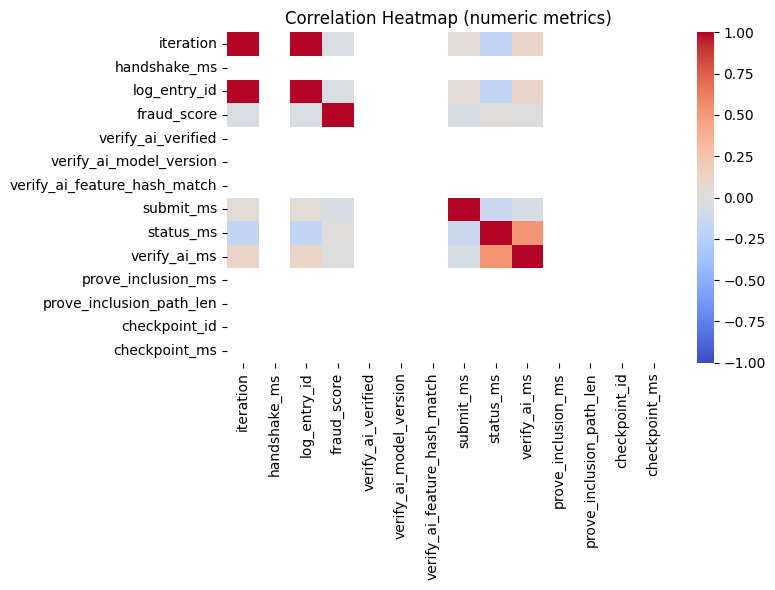

In [13]:
# Correlation heatmap between numeric metrics
num_cols = [c for c in df.columns if df[c].dtype.kind in 'fi']
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
if 'sns' in globals() and HAVE_SNS:
    sns.heatmap(corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
else:
    plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation Heatmap (numeric metrics)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'correlation_heatmap.png'), dpi=150)
plt.show()
